Imports and declarations
========================

In [1]:
import pandas as pd;
import logging;
import opTools.opUtils.io_utils as opio;
import opTools.data_re_format as data_preparation

log = logging.getLogger(" Quick-research ");
logging.basicConfig(level="INFO")

def log_df(df, title):
    s = f"*  {title}\n   {len(title) * "="}"
    print(f"\n{s}:\n   columns:{df.shape[1]} x rows:{df.shape[0]}");
    

2024-05-08 20:44:32.753033: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
CONFIG = opio.load_configuration("quick_ann_step_executor.conf.yml");
log.info(f"Configuration: v{CONFIG["version"]}\n\n{CONFIG["info"]}");

SCENARIO = CONFIG["scenario"];

INFO: Quick-research :Configuration: v1.0

The multiparameter, per-segment  power consumption forecast algorithm



Split data by segment change
============================

In [4]:
import opTools.data_loader as data_loader;

step_name, step_config = SCENARIO[0]
df = data_loader.execute(None, **step_config["data_source"])[0];
log_df(df, f"{step_name}: - Load raw data from file");

step_name, step_config = SCENARIO[1]
df_source = data_preparation.execute(df, **step_config["processing"])
log_df(df_source, f"{step_name}: - reformat to data source")

# CSV Raw Input data
df_source.head(2)

INFO:opTools.opUtils.io_utils:Extract the '6000_frames_20221124+25_new.csv' files data from the './DATA/6000_frame.zip' ZIP archive.



*  data_loader: - Load raw data from file
   ======================================:
   columns:50 x rows:67223

*  data_preparation: - reformat to data source
   ===========================================:
   columns:11 x rows:27000


,Timestamp,Battery cell voltage,ActualSpeed_L,ActualSpeed_R,Current segment,Speed,Cumulative energy consumption,Momentary current consuption,Momentary energy consumption,Momentary power consumption,Mass
Timestamp,,,,,,,,,,,
2022-11-25 11:14:58.607783,2022-11-25 11:14:58.607783,42670.0,81.0,147.0,42.0,0.152438,888.0,7580.0,1302.0,323.0,200.0
2022-11-25 11:14:59.051414,2022-11-25 11:14:59.051414,42670.0,89.0,157.0,42.0,0.169731,888.0,7580.0,1302.0,323.0,200.0


In [4]:
import opTools.data_segmentation as seg

step_name, step_config = SCENARIO[2]
dfs_list, dfs_grouped = seg.execute(df_source, **step_config["processing"]);
print(f"{step_name}: - splittered route to {len(dfs_list)} segments with {len(dfs_grouped)} unique segments")


data_segmentation: - splittered route to 704 segments with 26 unique segments


In [5]:
import opTools.build_per_segment_statistics as proc
step_name, step_config = SCENARIO[3]
df_segments_route, df_segments_dictionary = proc.execute((dfs_list, dfs_grouped), **step_config["processing"]) 

In [6]:
log_df(df_segments_route, "train route in segments");
log_df(df_segments_dictionary, "averaged segments statistics dictonary");

# Explicit ANN input
df_segments_route.head(5)


*  train route in segments
   =======================:
   columns:8 x rows:704

*  averaged segments statistics dictonary
   ======================================:
   columns:7 x rows:26


,Segment,Mass,Samples count,Day hour,Duration,Start segment voltage,End segment voltage,Voltage delta
0,42.0,200.0,19.0,11.0,9.0,42670.0,42670.0,0.0
1,41.0,200.0,43.0,11.0,22.0,42670.0,42670.0,0.0
2,9.0,200.0,22.0,11.0,11.0,42670.0,42670.0,0.0
3,19.0,200.0,10.0,11.0,4.0,42670.0,42670.0,0.0
4,56.0,200.0,13.0,11.0,5.0,42670.0,42670.0,0.0


Neural Network Building
=======================

In [7]:
import numpy as np;
df = df_segments_route;

step_name, step_config = SCENARIO[4]
df_raw = data_preparation.execute(df, **step_config["processing"])
df_raw.index = np.arange(df_raw.shape[0]);
df_raw.dropna(axis=0);

In [8]:
step_name, step_config = SCENARIO[5]
ann_params = step_config["processing"]

print(f"{step_name}: - build the ann")
log.debug(f"Building with parameters: {ann_params}")

LEARN_COUNT = ann_params["learn_samples_count"];
PREDICT_COUNT = ann_params["forecasted_samples_count"];
INPUT_NEURONS_COUNT = ann_params["input_neurons_per_parameter"];
HIDDEN_NEURONS_COUNT = ann_params["hidden_layer_neurons_per_parameter"];

EPOCHS_COUNT = ann_params["epochs_count"];
COUNT_BATCH_SIZE = ann_params["batch_size"];

all_columns = ann_params["input_parameters"];
STATIC_PARAMETERS = ann_params["static_parameters"]
predicted_parameters = ann_params["forecast_parameters"];


construct_ann: - build the ann


In [9]:
from opTools.opUtils.data_preprocessing import normalize_data, re_normalize_data;
df_raw = df_raw.loc[0:LEARN_COUNT + PREDICT_COUNT + INPUT_NEURONS_COUNT - 1 ,:]

df1, min_max = normalize_data(df_raw);
df1.shape

(400, 5)

In [10]:
from UTILS.anns_utils_py import df_to_shifted_tables, build_multiparamiters_model,predict_time_window_with_knowns;
x_train, y_train, x_test, y_test = df_to_shifted_tables(df1, INPUT_NEURONS_COUNT, LEARN_COUNT)

 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage


In [11]:
(y_train.shape, y_test.shape, y_test.columns)

((350, 5),
 (38, 5),
 Index(['Segment', 'Samples count', 'Duration', 'Voltage delta',
        'Start segment voltage'],
       dtype='object'))

In [12]:
model = build_multiparamiters_model(all_columns, predicted_parameters, INPUT_NEURONS_COUNT, hiden_layer_neurons = HIDDEN_NEURONS_COUNT)

Neural Network Training
=======================

In [13]:
import time
start = time.time()
epochs_hist = model.fit(x_train, y_train[predicted_parameters], epochs = EPOCHS_COUNT, batch_size = COUNT_BATCH_SIZE)
end = time.time()
print(start,'... ',end, '=>', (end-start))

model.summary()

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0765 - mean_absolute_error: 0.2279
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0244 - mean_absolute_error: 0.1312
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0161 - mean_absolute_error: 0.1045
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0101 - mean_absolute_error: 0.0822
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0070 - mean_absolute_error: 0.0690
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0052 - mean_absolute_error: 0.0581
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0045 - mean_absolute_error: 0.0526
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0040 - mean_absolute_error: 0.0498
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0044 - mean_absolute_error: 0.0510
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0035 - mean_absolute_error: 0.0462
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inp_Segment         │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Inp_Samples_count   │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Inp_Duration        │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Inp_Voltage_delta   │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Inp_Start_segment_… │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 60)        │          0 │ Inp_Segment[0][0… │
│ (Concatenate)       │                   │            │ Inp_Samples_coun… │
│                     │                   │            │ Inp_Duration[0][… │
│                     │                   │            │ Inp_Voltage_delt… │
│                     │                   │            │ Inp_Start_segmen… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mid_Start_segment_… │ (None, 17)        │      1,037 │ concatenate[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ out_Start_segment_… │ (None, 1)         │         18 │ mid_Start_segmen… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,167 (12.38 KB)

 Trainable params: 1,055 (4.12 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,112 (8.25 KB)

In [14]:
# assessment of the quality of the model on the test set
scores = model.evaluate(x_test, y_test[predicted_parameters])


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0027 - mean_absolute_error: 0.0394


Forecasts:
==========

- Test ANN
  --------

In [15]:
ann_test = model.predict(x_test)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


- Forecast with the time-windows method
  -------------------------------------

In [16]:
# predict with the time-windows method
df_knowns = y_test.loc[LEARN_COUNT:LEARN_COUNT+PREDICT_COUNT+INPUT_NEURONS_COUNT, STATIC_PARAMETERS];

# df_knowns = y_test
ptw = predict_time_window_with_knowns(y_train, model, predicted_parameters, df_knowns)


(350, 5)
 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/Users/ozabolotnyy/myProjects/OLENA/plPolitech/PyANN/Archive_2/UTILS/anns_utils_py.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_predictions = pd.concat([df_predictions, df_predicted]);


 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 - Forecast static ann-inputs via the Stationary process modeling method
   ---------------------------------------------------------------------

In [17]:
route_in_sectors = df_raw.Segment[-PREDICT_COUNT:]

df_segments_dictionary.index = df_segments_dictionary.Segment
stationaty_means_forecasts = df_segments_dictionary.loc[route_in_sectors,STATIC_PARAMETERS]
stationaty_means_forecasts.index = route_in_sectors.index

stationaty_means_normalized, _ = re_normalize_data(stationaty_means_forecasts, min_max)
# stationaty_means_normalized[["Voltage delta", "Duration"]].plot()



In [18]:
voltage_0 = y_train.iloc[-1, :][ predicted_parameters].values[0]
stationary_forecast = [voltage_0 := voltage_0 - x for x in stationaty_means_normalized["Voltage delta"] ]
len(stationary_forecast)

38

- Time-Window Forecast with the modeled static parameters as the stationary processes
  -----------------------------------------------------------------------------------

In [19]:
ptw_real = predict_time_window_with_knowns(y_train, model, predicted_parameters, stationaty_means_normalized)


(350, 5)
 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage


/Users/ozabolotnyy/myProjects/OLENA/plPolitech/PyANN/Archive_2/UTILS/anns_utils_py.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_predictions = pd.concat([df_predictions, df_predicted]);


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage


In [20]:
df_preds = y_test.loc[:, predicted_parameters]
df_preds["model_test"] = ann_test
df_preds["pwd-predicted"] = ptw
df_preds["pwd-predicted-real"] = ptw_real


Forecasts results report
========================

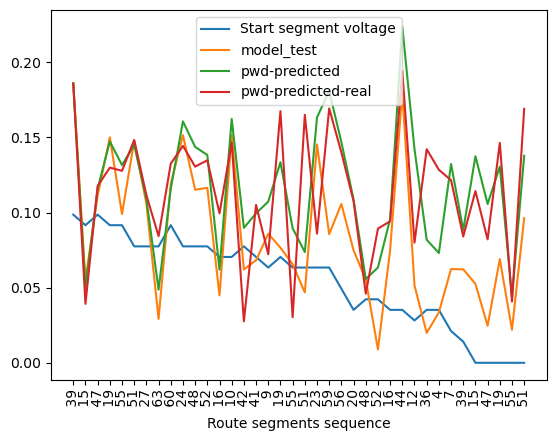

In [21]:
x_ticks = list((f"{t:3.0f}" for t in route_in_sectors.values))

plt = df_preds.plot();
plt.set_xlabel("Route segments sequence");
plt.set_xticks(route_in_sectors.index, x_ticks, rotation='vertical');

Export results
==============

In [22]:
from opTools import data_saver as export;

- Save data transformations
  -------------------------

In [23]:
export.execute([df, df_source, df_segments_route], ["1_raw_data.csv", "2_preformatted_data.csv", "3_route_in_segments.csv"],
                archive_file_name="input_data_processing.zip",  archive_path=[".", "DATA"]
              );

INFO:opTools.opUtils.io_utils:Archive the '1_raw_data.csv, 2_preformatted_data.csv, 3_route_in_segments.csv' files data to the './DATA/input_data_processing.zip' ZIP archive.
INFO:opTools.opUtils.io_utils:Exporting the 1_raw_data.csv
INFO:opTools.opUtils.io_utils:Exporting the 2_preformatted_data.csv
INFO:opTools.opUtils.io_utils:Exporting the 3_route_in_segments.csv


- Save trained ANN parameters
  ---------------------------

In [24]:
mm_df = pd.DataFrame().from_dict(min_max);
mm_df.index = ["Min", "Max"];

export.execute([df_segments_dictionary, mm_df, model], 
               ["segments_statistics.csv", "min_max_scale.csv", "ann_model.keras"],
                archive_file_name="ann_train_results.zip",  archive_path=[".", "DATA"]
              );

INFO:opTools.opUtils.io_utils:Archive the 'segments_statistics.csv, min_max_scale.csv, ann_model.keras' files data to the './DATA/ann_train_results.zip' ZIP archive.
INFO:opTools.opUtils.io_utils:Exporting the segments_statistics.csv
INFO:opTools.opUtils.io_utils:Exporting the min_max_scale.csv
INFO:opTools.opUtils.io_utils:Exporting the ann_model.keras


- Save result of forecasts on testing data set
  --------------------------------------------

In [25]:
export.execute([pd.DataFrame().from_dict({"Segments":x_ticks}),], 
                ["desired_route_segments.csv", ],
                archive_file_name="ann_forecast_inputs.zip",
                archive_path=[".", "DATA"]);

INFO:opTools.opUtils.io_utils:Archive the 'desired_route_segments.csv' files data to the './DATA/ann_forecast_inputs.zip' ZIP archive.
INFO:opTools.opUtils.io_utils:Exporting the desired_route_segments.csv


Use stored ANN MODEL to DO the FORECAST
=======================================

* Load the forecast config
  ------------------------

In [3]:
import logging;
import opTools.opUtils.io_utils as opio;

def log_df(df, title):
    s = f"*  {title}\n   {len(title) * "="}"
    print(f"\n{s}:\n   columns:{df.shape[1]} x rows:{df.shape[0]}");
    

CONFIG = opio.load_configuration("ann-forecast.conf.yml");

log = logging.getLogger(" Trained ANN Forecast ");
logging.basicConfig(**CONFIG["logging"])

log.info(f"Configuration: v{CONFIG["version"]}\n\n{CONFIG["info"]}");

SCENARIO = CONFIG["scenario"];

INFO: Trained ANN Forecast :Configuration: v1.0

The multiparameter, per-segment 
power consumption forecast algorithm 
- PART 2: FORECAST



- Load the trained ANN Model
  --------------------------

In [4]:
import opTools.data_loader as data_loader;

step_name, step_config = SCENARIO[0]
log.info(step_config["title"]);

df_segments_dictionary, mm_df, model  = data_loader.execute(None, **step_config["data_source"])
log_df(df_segments_dictionary, "Segments statistics data")
log_df(mm_df, "Data normalization info")
model.summary()

INFO: Trained ANN Forecast :Load trained ANN model

INFO:opTools.opUtils.io_utils:Extract the 'segments_statistics.csv, min_max_scale.csv, ann_model.keras' files data from the './DATA/ann_train_results.zip' ZIP archive.
DEBUG:opTools.opUtils.io_utils:The archive consists of: ['segments_statistics.csv', 'min_max_scale.csv', 'ann_model.keras']



*  Segments statistics data
   ========================:
   columns:8 x rows:26

*  Data normalization info
   =======================:
   columns:6 x rows:2


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inp_Segment         │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Inp_Samples_count   │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Inp_Duration        │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Inp_Voltage_delta   │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Inp_Start_segment_… │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 60)        │          0 │ Inp_Segment[0][0… │
│ (Concatenate)       │                   │            │ Inp_Samples_coun… │
│                     │                   │            │ Inp_Duration[0][… │
│                     │                   │            │ Inp_Voltage_delt… │
│                     │                   │            │ Inp_Start_segmen… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mid_Start_segment_… │ (None, 17)        │      1,037 │ concatenate[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ out_Start_segment_… │ (None, 1)         │         18 │ mid_Start_segmen… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,167 (12.38 KB)

 Trainable params: 1,055 (4.12 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,112 (8.25 KB)

* Load the RAW historical window data
  -----------------------------------

In [6]:
step_name, step_config = SCENARIO[1]
log.info(step_config["title"]);

df_raw, = data_loader.execute(None, **step_config["data_source"]);
log_df(df_raw, "raw inputs")


INFO: Trained ANN Forecast :Load raw input data

INFO:opTools.opUtils.io_utils:Extract the '2_preformatted_data.csv' files data from the './DATA/input_data_processing.zip' ZIP archive.
DEBUG:opTools.opUtils.io_utils:The archive consists of: ['1_raw_data.csv', '2_preformatted_data.csv', '3_route_in_segments.csv']



*  raw inputs
   ==========:
   columns:12 x rows:27000


* data clean up
  -------------

In [9]:
import opTools.data_re_format as data_preparation

step_name, step_config = SCENARIO[2]
log.info(step_config["title"]);

df_source = data_preparation.execute(df_raw, **step_config["processing"])
log_df(df_source, f"{step_name}: - cleared raw data")


INFO: Trained ANN Forecast :Sanity data clean up



*  data_preparation: - cleared raw data
   ====================================:
   columns:11 x rows:26999


* Data segmentations
  ------------------

In [10]:
import opTools.data_segmentation as seg

step_name, step_config = SCENARIO[3]
log.info(step_config["title"]);

dfs_list, dfs_grouped = seg.execute(df_source, **step_config["processing"]);
print(f"{step_name}: - splittered route to {len(dfs_list)} segments with {len(dfs_grouped)} unique segments")

INFO: Trained ANN Forecast :Splitering route by segments
DEBUG:opTools.data_segmentation:splittering historical data for different Current segment column values
DEBUG:opTools.data_segmentation:Redefining route in segments
DEBUG:opTools.data_segmentation:Group statisics by segments


data_segmentation: - splittered route to 704 segments with 26 unique segments


In [12]:
import opTools.build_per_segment_statistics as proc
step_name, step_config = SCENARIO[4]

df_segments_route, df_segments_dictionary = proc.execute((dfs_list, dfs_grouped), **step_config["processing"]) 
log_df(df_segments_route, "train route in segments");


*  train route in segments
   =======================:
   columns:8 x rows:704


* determine ANN parameters
  ------------------------

In [39]:
step_name, step_config = SCENARIO[6]
ann_params = step_config["processing"];
INPUT_NEURONS_COUNT = model.input[0].shape[1];

STATIC_PARAMETERS = ann_params["static_parameters"];
predicted_parameters = ann_params["forecast_parameters"];
all_params = ann_params['input_parameters'];

df_inouts_historical_data = df_segments_route[all_params].iloc[-INPUT_NEURONS_COUNT-1:,:]

df_inouts_historical_data

,Segment,Samples count,Duration,Voltage delta,Start segment voltage
691,15.0,21.0,9.0,-10.0,39640.0
692,47.0,26.0,12.0,-30.0,39630.0
693,19.0,8.0,3.0,0.0,39600.0
694,55.0,13.0,5.0,-10.0,39600.0
695,51.0,10.0,4.0,-10.0,39590.0
696,27.0,21.0,10.0,-20.0,39580.0
697,63.0,38.0,18.0,-20.0,39560.0
698,60.0,28.0,15.0,-30.0,39540.0
699,24.0,22.0,10.0,-10.0,39510.0
700,48.0,11.0,4.0,-10.0,39500.0


 - SEE - Forecast static ann-inputs via the Stationary process modeling method
   ---------------------------------------------------------------------------

In [88]:
import numpy as np

route_in_sectors = df_inouts_historical_data.Segment[::-1]
route_in_sectors.index = route_in_sectors.index[0] + np.arange(route_in_sectors.shape[0])

In [97]:
from opTools.opUtils.data_preprocessing import normalize_data, re_normalize_data;

df_segments_dictionary.index = df_segments_dictionary.Segment
stationaty_means_forecasts = df_segments_dictionary.loc[route_in_sectors,STATIC_PARAMETERS]
stationaty_means_forecasts.index = route_in_sectors.index

min_max = mm_df[all_params].to_dict()
stationaty_means_normalized, _ = re_normalize_data(stationaty_means_forecasts, min_max)


In [98]:
from UTILS.anns_utils_py import df_to_shifted_tables, build_multiparamiters_model,predict_time_window_with_knowns;

# x_train, y_train, x_test, y_test = df_to_shifted_tables(df_inouts_historical_data, INPUT_NEURONS_COUNT, 0)
ptw_real = predict_time_window_with_knowns(, model, predicted_parameters, stationaty_means_normalized)


 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage


- arrange input data as historical windows
  ----------------------------------------

In [24]:
x_test[0]

{'Segment':      t-12  t-11  t-10   t-9   t-8   t-7   t-6   t-5   t-4   t-3   t-2   t-1
 703  15.0  47.0  19.0  55.0  51.0  27.0  63.0  60.0  24.0  48.0  52.0  16.0}

In [50]:
df_inouts_historical_data.Segment[-1:]

703    10.0
Name: Segment, dtype: float64

In [17]:
parameters_count = len(model.input_shape)
inputs_per_parameter_count = model.input_shape[0][1]
print (parameters_count, inputs_per_parameter_count)

5 12


In [18]:
model.input

[<KerasTensor shape=(None, 12), dtype=float32, sparse=False, name=Inp_Segment>,
 <KerasTensor shape=(None, 12), dtype=float32, sparse=False, name=Inp_Samples_count>,
 <KerasTensor shape=(None, 12), dtype=float32, sparse=False, name=Inp_Duration>,
 <KerasTensor shape=(None, 12), dtype=float32, sparse=False, name=Inp_Voltage_delta>,
 <KerasTensor shape=(None, 12), dtype=float32, sparse=False, name=Inp_Start_segment_voltage>]

In [28]:
SCENARIO[6]

('construct_ann',
 {'processing': {'input_parameters': ['Segment',
    'Samples count',
    'Duration',
    'Voltage delta',
    'Start segment voltage'],
   'static_parameters': ['Segment',
    'Samples count',
    'Duration',
    'Voltage delta'],
   'forecast_parameters': ['Start segment voltage'],
   'input_neurons_per_parameter': 12,
   'hidden_layer_neurons_per_parameter': 17,
   'learn_samples_count': 350,
   'forecasted_samples_count': 38,
   'epochs_count': 50,
   'batch_size': 15}})

In [31]:
ann_params

{'processing': {'input_parameters': ['Segment',
   'Samples count',
   'Duration',
   'Voltage delta',
   'Start segment voltage'],
  'static_parameters': ['Segment',
   'Samples count',
   'Duration',
   'Voltage delta'],
  'forecast_parameters': ['Start segment voltage'],
  'input_neurons_per_parameter': 12,
  'hidden_layer_neurons_per_parameter': 17,
  'learn_samples_count': 350,
  'forecasted_samples_count': 38,
  'epochs_count': 50,
  'batch_size': 15}}